In [60]:
from darts.datasets import AirPassengersDataset

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, kpss

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchsummary

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from einops import rearrange

from scipy.optimize import curve_fit

In [80]:
### FINAL RESULTS (Comment this box and run everything. Then Uncomment and Run this.)


# Missing Models : Theta, SARIMAX, VARMAX

data = {
    'Average': [rmse_mean, mae_mean, mape_mean],
    'Naive': [rmse_naive, mae_naive, mape_naive],
    'Seasonal Naive': [rmse_snaive, mae_snaive, mape_snaive],
    'Drift': [rmse_drift, mae_drift, mape_drift],
    'ETS Simple': [rmse_ses, mae_ses, mape_ses],
    'ETS-HW-damped': [rmse_sest, mae_sest, mape_sest],
    'ETS-HW-seasonal-damped': [rmse_sess, mae_sess, mape_sess],
    'ARIMA': [rmse_arima, mae_arima, mape_arima],
    'SARIMA': [rmse_sarima, mae_sarima, mape_sarima],
}
index = ['RMSE', 'MAE', 'MAPE']

scores = pd.DataFrame(data, index=index)
scores.T.sort_values('MAPE')


,RMSE,MAE,MAPE
SARIMA,27.900277,22.800693,0.052741
ARIMA,29.728309,23.931964,0.054440
ETS-HW-seasonal-damped,37.968714,30.998194,0.072212
ETS Simple,93.068647,81.386172,0.165796
Naive,93.133941,81.448276,0.165882
Seasonal Naive,75.233888,64.758621,0.171677
ETS-HW-damped,100.987024,90.019762,0.177520
Drift,112.908874,101.551483,0.193152
Average,215.057269,200.362519,0.835025


### 1. Load Dataset

In [62]:
dataset = AirPassengersDataset()
time_series = dataset.load()
time_series.head(20)

<TimeSeries (DataArray) (Month: 20, component: 1, sample: 1)> Size: 160B
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

       [[104.]],

       [[118.]],

       [[115.]],

       [[126.]],

       [[141.]],

       [[135.]],

       [[125.]],

       [[149.]],

       [[170.]],

       [[170.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 160B 1949-01-01 1949-02-01 ... 1950-08-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 2. Train Test Split

(115, 1)
(29, 1)


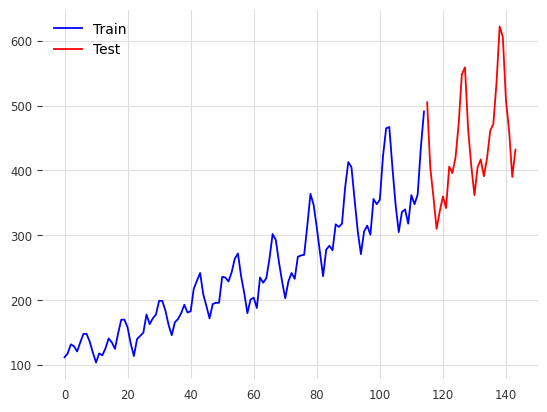

In [63]:
## Train and Test Splitting of Time Series Data
X = time_series.values()
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()


### 3. Baseline Models



#### 3.1 Mean

Forecast of future values is mean of the time series. 
\begin{equation}
\hat{y}_{T+h|T} =  \overline{y}
\end{equation}

[239.94782609]
(29,)


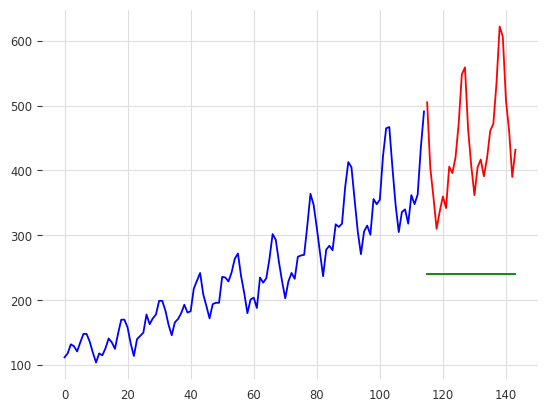

215.05726867296002 200.3625187406297 0.8350253553371172


In [64]:
y_mean = np.mean(X_train, axis=0)
print(y_mean)
y_pred_mean = np.tile(y_mean, len(X_test))
print(y_pred_mean.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_mean, c='green', label='Mean')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.show()

rmse_mean = np.sqrt(mean_squared_error(y_pred_mean, X_test))
mae_mean = mean_absolute_error(y_pred_mean, X_test)
mape_mean = mean_absolute_percentage_error(y_pred_mean, X_test)

print(rmse_mean, mae_mean, mape_mean)


#### 3.2 Naive

Forecast of future values is last observed value of the time series.
\begin{equation}
\hat{y}_{T+h|T} =  y_T
\end{equation}

[491.]
(29,)


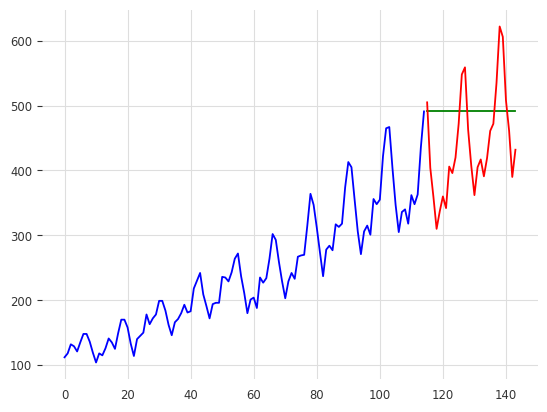

93.13394136662937 81.44827586206897 81.44827586206897


In [65]:
y_naive = X_train[-1]
print(y_naive)

y_pred_naive = np.tile(y_naive, len(X_test))
print(y_pred_naive.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_naive, c='green', label='Naive')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.show()

rmse_naive = np.sqrt(mean_squared_error(y_pred_naive, X_test))
mae_naive = mean_absolute_error(y_pred_naive, X_test)
mape_naive = mean_absolute_percentage_error(y_pred_naive, X_test)

print(rmse_naive, mae_naive, mae_naive)

#### 3.3 Seasonal Naive

Forcast of future values is last observed value of the same season from previous cycle.
\begin{equation}
\hat{y}_{T+h|T} =  y_{T+h -m(k+1)}
\end{equation}

where m = seasonal period, $k=\frac{h-1}{m}$ integer part.

(29, 1)


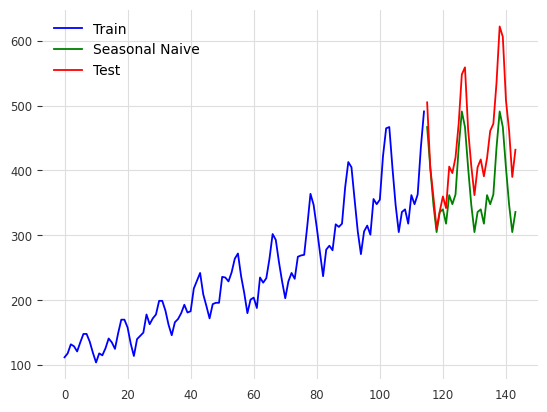

75.23388818235092 64.75862068965517 64.75862068965517


In [66]:
def snaive(x, period=12, pred_length=None):
    season = x[-period:]

    k = pred_length // period
    forecasts = season.copy()
    for i in range(k):
        forecasts = np.vstack([forecasts, season])

    return forecasts[:pred_length]
    

y_pred_snaive = snaive(X_train, period=12, pred_length=len(X_test))
print(y_pred_snaive.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_snaive, c='green', label='Seasonal Naive')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_snaive = np.sqrt(mean_squared_error(y_pred_snaive, X_test))
mae_snaive = mean_absolute_error(y_pred_snaive, X_test)
mape_snaive = mean_absolute_percentage_error(y_pred_snaive, X_test)

print(rmse_snaive, mae_snaive, mae_snaive)


#### 3.4 Drift

Forecast of future values is average change over time.

\begin{equation}
\hat{y}_{T+h|T} =  y_T + h (\frac{y_T - y_1}{T - 1})
\end{equation}

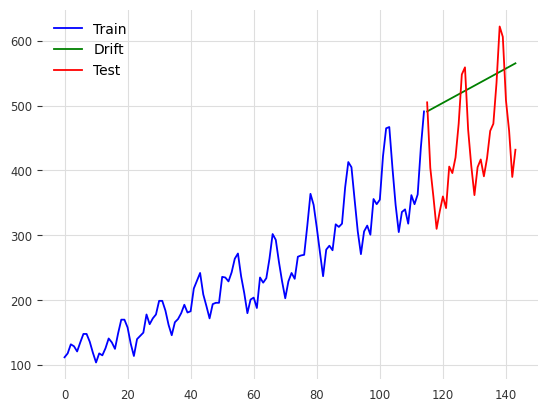

112.90887399504554 101.55148299975889 0.1931522140383206


In [67]:
def drift(x, pred_length):

    def linear_func(x, m , b):
        return m * x + b

    b = x[-1,0]
    m = (x[-1, 0] - x[0,0]) / (len(X) - 1)
    forecast = []
    for i in range(pred_length):
        forecast.append(linear_func(i, m, b))
    return np.array(forecast)



y_pred_drift = drift(X_train, len(X_test))
y_pred_drift

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_drift, c='green', label='Drift')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_drift = np.sqrt(mean_squared_error(y_pred_drift, X_test))
mae_drift= mean_absolute_error(y_pred_drift, X_test)
mape_drift = mean_absolute_percentage_error(y_pred_drift, X_test)

print(rmse_drift, mae_drift, mape_drift)



#### 3.5 Exponential Smoothing

**Simple Exponential Smoothing**

(29,)


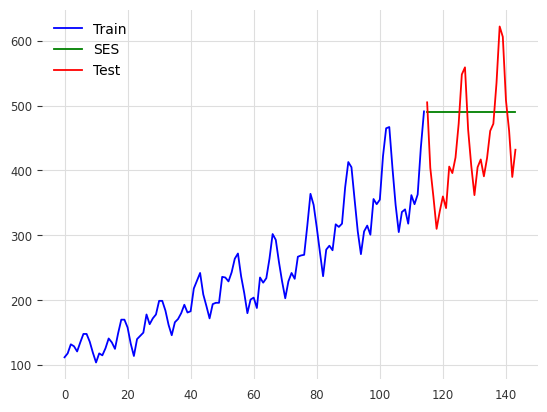

93.06864683063684 81.38617163777474 0.16579649392849405


In [68]:
ses = ExponentialSmoothing(X_train)
ses_fit = ses.fit()

y_pred_ses = ses_fit.predict(start=len(X_train), end=len(X_train) + len(X_test)-1)
print(y_pred_ses.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_ses, c='green', label='SES')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_ses = np.sqrt(mean_squared_error(y_pred_ses, X_test))
mae_ses= mean_absolute_error(y_pred_ses, X_test)
mape_ses = mean_absolute_percentage_error(y_pred_ses, X_test)

print(rmse_ses, mae_ses, mape_ses)

**Holt-Winter Method**(damped trend)

(29,)


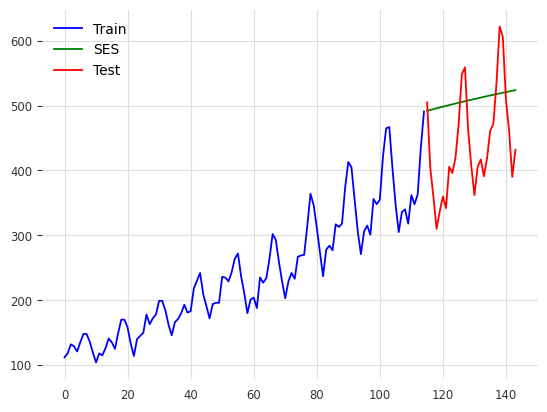

100.98702353713284 90.01976168483816 0.1775204485293449


In [69]:
ses = ExponentialSmoothing(X_train, trend="add", damped_trend=True)
ses_fit = ses.fit()

y_pred_ses = ses_fit.predict(start=len(X_train), end=len(X_train) + len(X_test)-1)
print(y_pred_ses.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_ses, c='green', label='SES')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_sest = np.sqrt(mean_squared_error(y_pred_ses, X_test))
mae_sest= mean_absolute_error(y_pred_ses, X_test)
mape_sest = mean_absolute_percentage_error(y_pred_ses, X_test)

print(rmse_sest, mae_sest, mape_sest)

**Holt-Winter Method**(with Seasonality)

(29,)


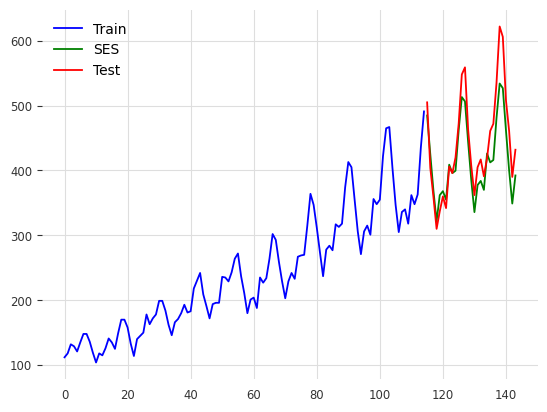

37.9687138770979 30.998193723660947 0.07221177086271713


In [70]:
ses = ExponentialSmoothing(X_train, trend="add", damped_trend=True, seasonal="mul", seasonal_periods=12)
ses_fit = ses.fit()

y_pred_ses = ses_fit.predict(start=len(X_train), end=len(X_train) + len(X_test)-1)
print(y_pred_ses.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_ses, c='green', label='SES')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_sess = np.sqrt(mean_squared_error(y_pred_ses, X_test))
mae_sess= mean_absolute_error(y_pred_ses, X_test)
mape_sess = mean_absolute_percentage_error(y_pred_ses, X_test)

print(rmse_sess, mae_sess, mape_sess)

### 4. ARIMA

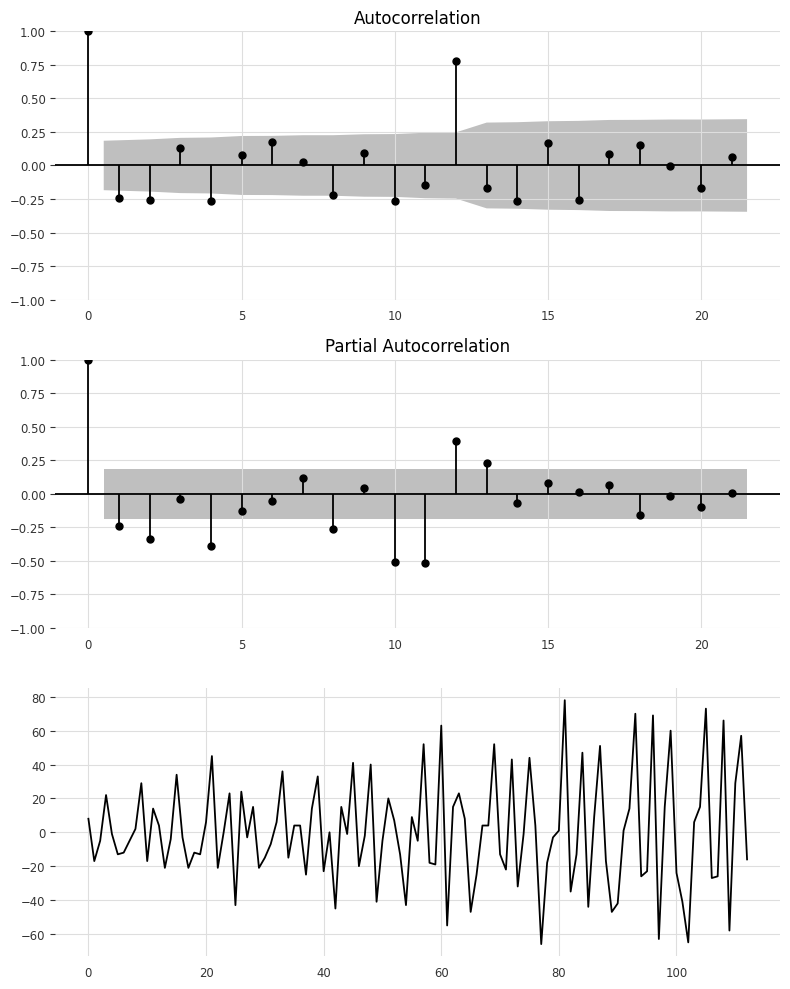

In [71]:
### Analysis section for ARIMA for find p, d, q


X_plots = X_train.copy()
X_plots = diff(X_plots, k_diff=2)

fig, axs = plt.subplots(3, figsize=(8, 10))
axs[2].plot(X_plots)
plot_acf(X_plots, ax=axs[0])
plot_pacf(X_plots, ax=axs[1])
plt.tight_layout()
plt.show()


#ADF and KPSS Test


/home/aditya/Documents/test-transformer/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aditya/Documents/test-transformer/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(29,)


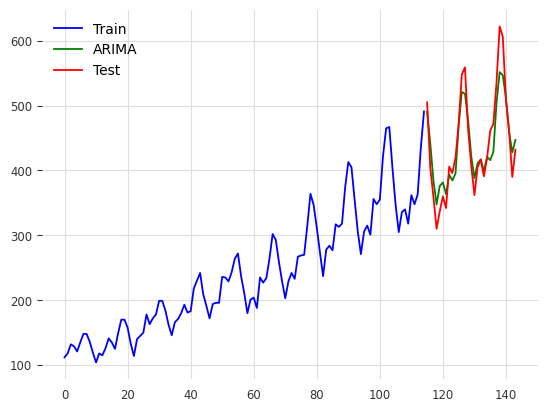

29.728308715399308 23.931963998180496 0.05443977908867227


In [72]:
arima = ARIMA(X_train, order=(12,2,11))
arima_fit = arima.fit()

y_pred_arima = arima_fit.predict(start=len(X_train), end=len(X_train) + len(X_test)-1)
print(y_pred_arima.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_arima, c='green', label='ARIMA')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_arima = np.sqrt(mean_squared_error(y_pred_arima, X_test))
mae_arima= mean_absolute_error(y_pred_arima, X_test)
mape_arima = mean_absolute_percentage_error(y_pred_arima, X_test)

print(rmse_arima, mae_arima, mape_arima)

### 5. SARIMA

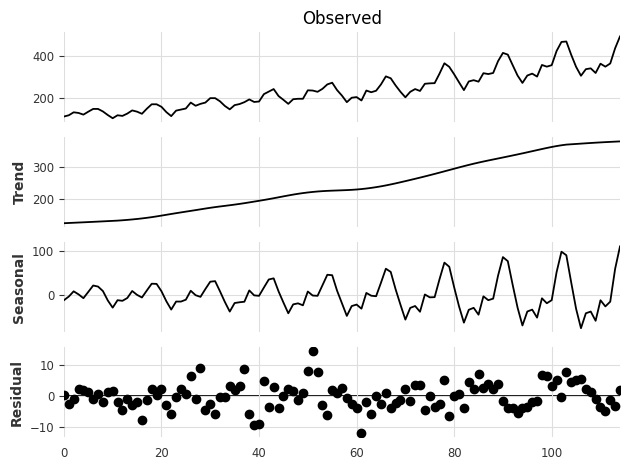

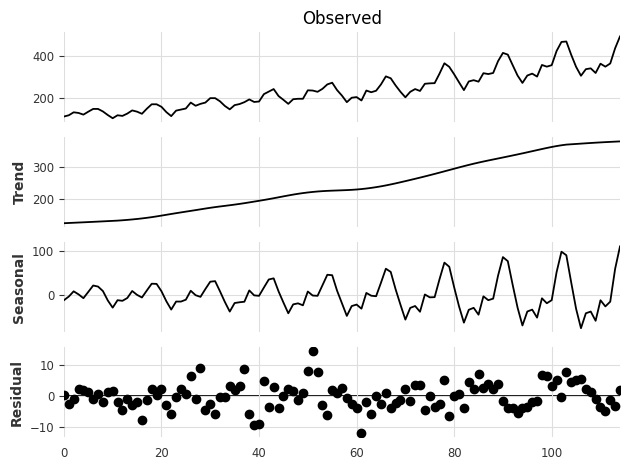

In [73]:
### Analysis section for ARIMA for find p, d, q


X_plots = X_train.copy()
decompose = STL(X_plots, period=12).fit()
decompose.plot()




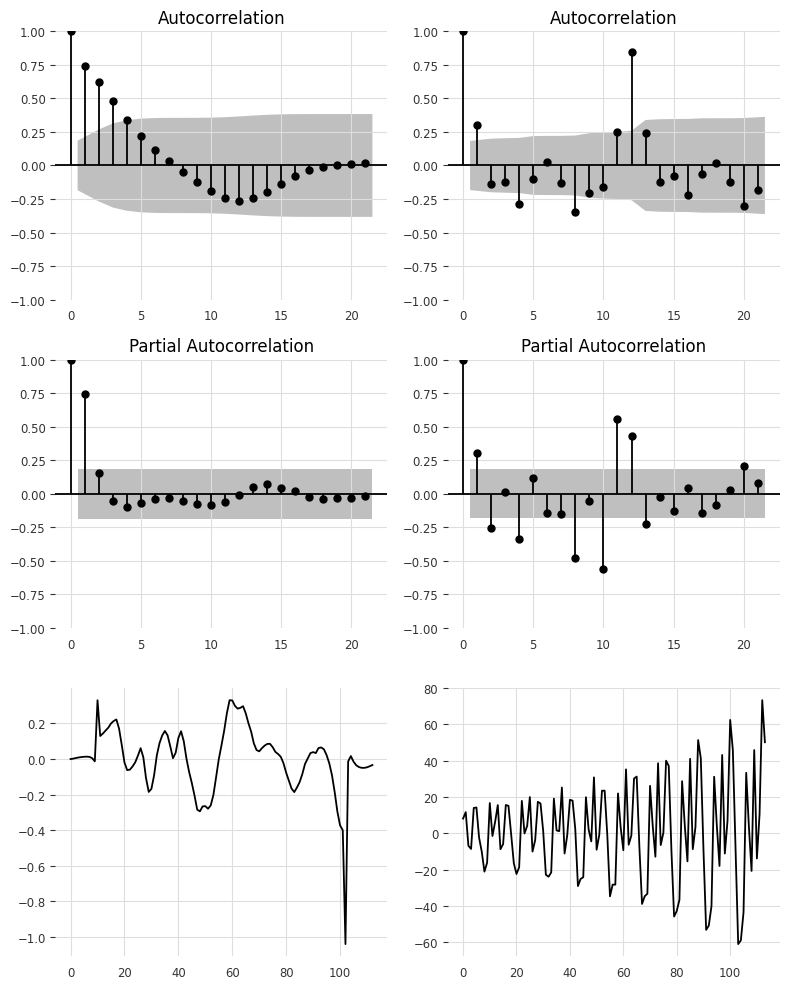

In [74]:
decompose.trend

trend = diff(decompose.trend, k_diff=2)
seasonal = diff(decompose.seasonal, k_diff=1)
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 10))

# Trend on LEft
axs[2][0].plot(trend)
plot_acf(trend, ax=axs[0][0])
plot_pacf(trend, ax=axs[1][0])

# Seasonal on RIGHT
axs[2][1].plot(seasonal)
plot_acf(seasonal, ax=axs[0][1])
plot_pacf(seasonal, ax=axs[1][1])

plt.tight_layout()
plt.show()

In [75]:
# ADFuller -> Null Hypothesis is data is non-stationary
# KPSS -> Null hypothesis is data /trend is stationary. 

print(f"P-Value ADFuller for trend: {adfuller(trend)[1]}") 
print(f"P-Value KPSS for trend: {kpss(trend)[1]}")

print(f"P-Value ADFuller for seasonal: {adfuller(seasonal)[1]}")
print(f"P-Value KPSS for seasonal: {kpss(seasonal)[1]}")

P-Value ADFuller for trend: 0.0013466842231514477
P-Value KPSS for trend: 0.1
P-Value ADFuller for seasonal: 9.816561504600509e-10
P-Value KPSS for seasonal: 0.1


/tmp/ipykernel_5324/1720844669.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"P-Value KPSS for trend: {kpss(trend)[1]}")
/tmp/ipykernel_5324/1720844669.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"P-Value KPSS for seasonal: {kpss(seasonal)[1]}")


(29,)


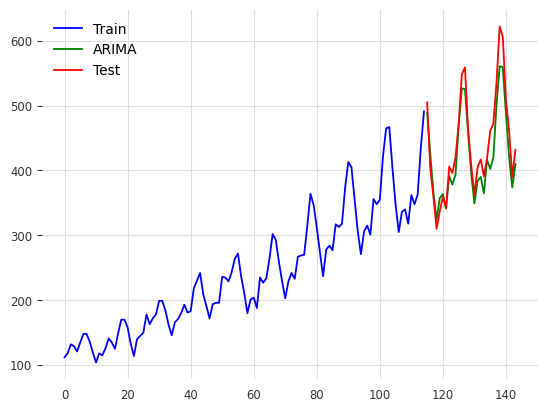

27.90027679186035 22.800693101355865 0.052740559156729906


In [76]:
sarima = ARIMA(X_train, order=(2,1,2), seasonal_order=(2,1,1,12))
sarima_fit = sarima.fit()

y_pred_sarima = sarima_fit.predict(start=len(X_train), end=len(X_train) + len(X_test)-1)
print(y_pred_arima.shape)

plt.figure()
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred_sarima, c='green', label='ARIMA')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
plt.legend()
plt.show()

rmse_sarima = np.sqrt(mean_squared_error(y_pred_sarima, X_test))
mae_sarima= mean_absolute_error(y_pred_sarima, X_test)
mape_sarima = mean_absolute_percentage_error(y_pred_sarima, X_test)

print(rmse_sarima, mae_sarima, mape_sarima)

### 6. Theta 